**Note**

This is an example of a non-tidy analysis. This should be compared to the tidied analysis.

In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

%matplotlib inline
# Make graphs in SVG format
%config InlineBackend.figure_formats = ['svg']

# Employee retention dataset

We are going to some exploratory data analysis on employee retention data. Specifically we are interested in what are the effects that most influence retention.

## Data import and conversion

In [19]:
emps = pd.read_csv('employee_retention_data.csv')
emps.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


Let's look at the data types, and the number of missing values, to look for integrity issues:

In [37]:
emps.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [20]:
emps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


Okay, the only column with missing values are the `quit_date`s. This makes sense, because we have employees that haven't quit yet. We see that the column data types are all correct _except_ for the last two columns (which should be dates). The `quit_date` we don't know what to do with since some of the people haven't quit yet, but the other column we should convert.

In [81]:
emps['join_date'] = pd.to_datetime(emps['join_date'])
emps['quit_date'] = pd.to_datetime(emps['quit_date'])

## Initial exploration

We don't know what questions to ask until we have done some exploration! Brainstorming some potential things that may influence retention:
- start year: there might be generational attitudes toward company loyalty. This is something we cannot affect directly, but we might need to control for.
- department: job expectations might be different in different fields. Some fields are "hot" at different times, which would enable people to move easier. We might also have culture issues in one department that are not present in others. We cannot change the market, but we can culture within a deparmtent, or offer better pacakges in high turnover departmenst.
- salary: we expect increasing salary to reduce turnover.

In [239]:
# How imbalanced is the dataset? What fraction have left?
emps['have_left'].value_counts()

True     13510
False    11192
Name: have_left, dtype: int64

Okay, a little over half of people employed since the beginning of the dataset are still employed.

### Time membership

In [43]:
min(emps.join_date), max(emps.join_date)

(Timestamp('2011-01-24 00:00:00'), Timestamp('2015-12-10 00:00:00'))

Okay, we are looking at jobs over 2011 -- 2015. We probably don't have to care about which year the salaries are in, or "generational" changes in the attitude of working for employers.

We should get some idea of what the distribution is of how long people stay at the company and what patterns there are.

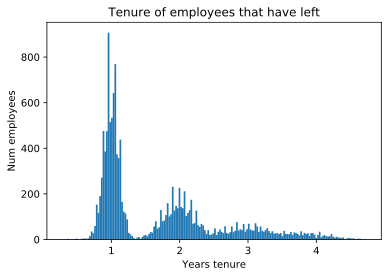

In [149]:
emps['tenure'] = emps['quit_date'] - emps['join_date']
emps_left = emps[emps['have_left']].copy()
plt.hist(emps_left.tenure.dt.days/365, bins=180);
plt.xlabel('Years tenure')
plt.ylabel('Num employees')
plt.title('Tenure of employees that have left');

We have big movement around the one year mark. For companies that offer options or stock, there is usually a one-year cliff (i.e. you only get shares once you have been at the company a year). There is also the general advice to not switch jobs more frequently than once a year. We see there are people that leave roughly around there "anniversaries".

Many of the current employees have been with the company less than one year, so we would not have expected them to churn out yet. Putting a direct number of this:

In [138]:
(tenure_so_far.dt.days < 365).sum()/len(tenure_so_far)

0.443084345961401

i.e. 44% of employees still employed haven't reached their one year date.

### Department membership

In [32]:
# Are the departments balanced?
emps['dept'].value_counts()

customer_service    9180
engineer            4613
data_science        3190
sales               3172
marketing           3167
design              1380
Name: dept, dtype: int64

Text(0.5, 0, 'Number of employees')

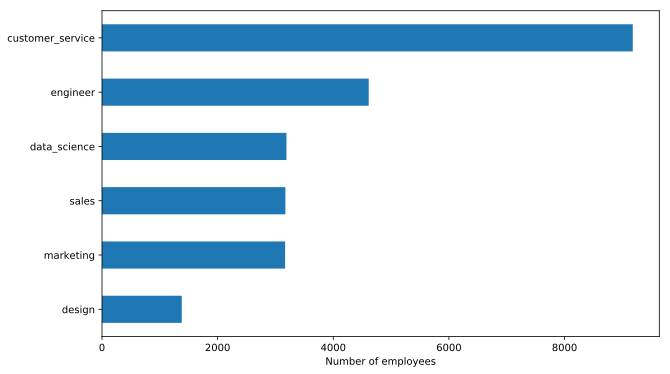

In [33]:
emps['dept'].value_counts(ascending=True).plot.barh(figsize=(10,6))
plt.xlabel('Number of employees')

We have enough people per department to be able to draw some inference. We are also curious what the salaries at the company looks like:
- overall
- per department

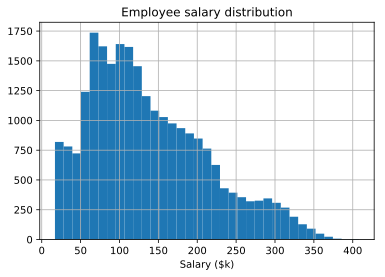

In [46]:
# Overall salary distribution
(emps['salary']/1000).hist(bins=35)
plt.xlabel('Salary ($k)')
plt.title("Employee salary distribution");

In [41]:
# is there a difference in distribution between those that have left and those that haven't
emps['have_left'] = ~(emps.quit_date.isna())

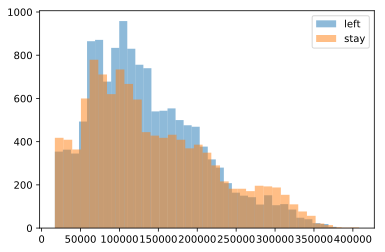

In [53]:
# is there a difference in distribution between those that have left
# and those that haven't?
plt.hist(emps.loc[emps['have_left'], 'salary'], bins=35, alpha=0.5, label='left');
plt.hist(emps.loc[~emps['have_left'], 'salary'], bins=35, alpha=0.5, label='stay');
plt.legend()

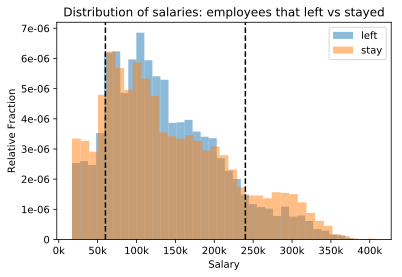

In [75]:
# Might lead to false conclusions based on the different raw numbers 
# (close to an even split, but 54% have left)
import matplotlib.ticker as tkr

plt.hist(emps.loc[emps['have_left'], 'salary'], bins=35, alpha=0.5, label='left', density=True);
plt.hist(emps.loc[~emps['have_left'], 'salary'], bins=35, alpha=0.5, label='stay', density=True);
plt.gca().yaxis.set_major_formatter(tkr.StrMethodFormatter('{x:,.0g}'))
plt.gca().xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, _: f'{int(x/1000):d}k'))
plt.xlabel('Salary')
plt.ylabel('Relative Fraction')
plt.title('Distribution of salaries: employees that left vs stayed')
lower_cut = 60_000
upper_cut = 240_000
plt.gca().axvline(lower_cut, ls='--', c='k')
plt.gca().axvline(upper_cut, ls='--', c='k')
plt.legend();

By eye we can see that employees that got paid between 60k and 260k were more likely to leave. There are a few (reasonable) confounders:
- different departments have different salary expectations; maybe mid-range departments have higher turnover in general?
- Salary should be correlated with how long you have already been at the company. We have the bulk of people leave around the one year mark, maybe 50k - 220k corresponds roughly to the starting salary? 

We haven't accounted for how long people have been at there current positions yet. Let's look at salary vs time in job for those that have left:

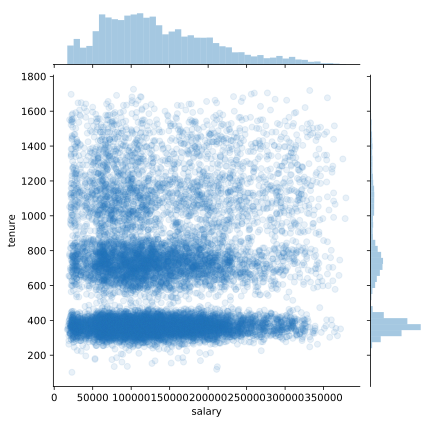

In [238]:
sns.jointplot(emps_left.salary, emps_left.tenure.dt.days, alpha=0.1, kind='scatter')
plt.gca().xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, _: f'{int(x/1000):d}k'))

We can see people who leave "early" (around the one year mark) tend to have salaries under ~250k, while those leaving around the two year mark leave if they earn under ~200k. In is a little hard to tell what is going on for the early leavers because of the density of plots. 

This does suggest the right way of framing the problem of what influences people leaving is to look at people who leave around the one year mark as the biggest issue, then at longer term employee retention as a separate problem.

Is this "one-year" tenure effect department dependent?

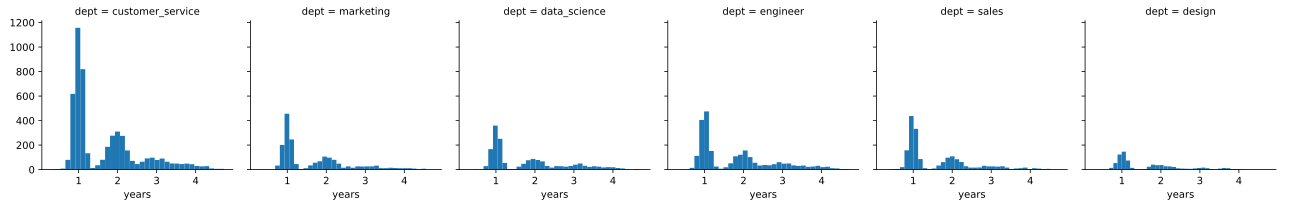

In [150]:

g = sns.FacetGrid(emps_left, col="dept")
emps_left['years'] = emps_left['tenure'].dt.days/365
g = g.map(plt.hist, 'years', bins=35)

This pattern seems consistent across departments. Normalizing for size:

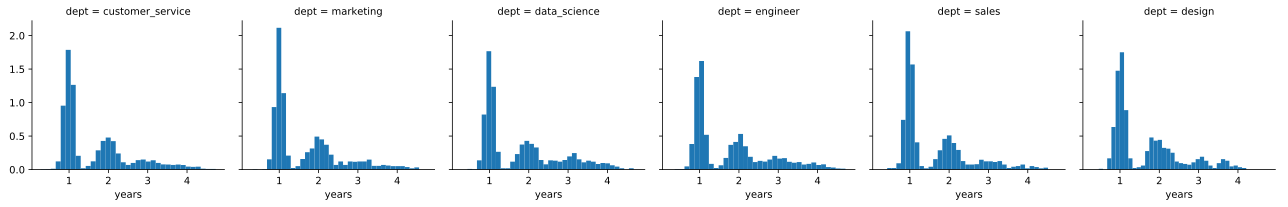

In [151]:
g = sns.FacetGrid(emps_left, col="dept")
g = g.map(plt.hist, 'years', bins=35, density=True)

What about people that have stayed? What is the distribution of their current times?

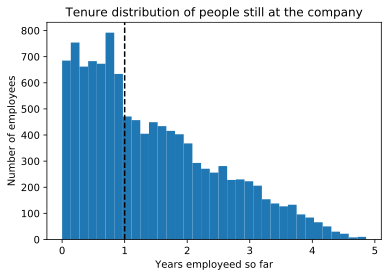

In [152]:
tenure_so_far = (max(emps['join_date']) - emps.loc[emps['have_left']==False, 'join_date'])
plt.gca().axvline(1, ls='--', c='k')
plt.hist(tenure_so_far.dt.days/365, bins=35)
plt.xlabel('Years employeed so far');
plt.ylabel('Number of employees')
plt.title('Tenure distribution of people still at the company');

Basically at this point it looks like we have two separate problems: what to do with people that have stayed less than "a year" and those that stayed longer than "a year". Since 1 year goes through the center of the histogram, we probably want to pick a cutoff that cleanly separates the two lumps. We can either do this by eye (in more complicated cases, we might choose to do kMeans with k = 3 or 4 to find the "best" cutoff).

Let's visualize a cut we could make:

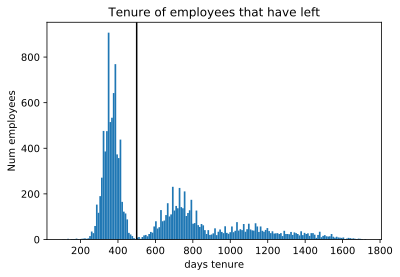

In [153]:
cutoff_days = 500
plt.hist(emps_left.tenure.dt.days, bins=180);
plt.xlabel('days tenure')
plt.ylabel('Num employees')
plt.title('Tenure of employees that have left')
plt.gca().axvline(cutoff_days, c='k');

We will define anyone who left earlier than 500 days of employment as "short employment", if you have been here longer than 500 days we will qualify you as "long employment"

In [241]:
emps_left['is_short'] = (emps_left['tenure'].dt.days < cutoff_days)

### Short employment?

What is the salary dependence for people with short leavers?

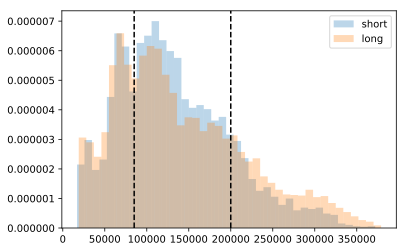

In [164]:
plt.hist(emps_left[emps_left['is_short']].salary, bins=40, alpha=0.3, density=True, label='short');
plt.hist(emps_left[~emps_left['is_short']].salary, bins=40, alpha=0.3, density=True, label='long');
plt.gca().axvline(85_000, c='k', ls='--')
plt.gca().axvline(200_000, c='k', ls='--')
plt.legend()

We see that people who only stay a short time tend to have salaries in the 85-200k range. The department is presumably a confounding variable here, as the salaries in different departments would look quite different.

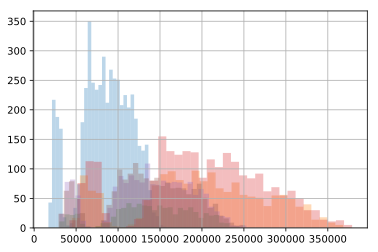

In [170]:
# histograms of salaries for reference
emps_left.groupby('dept').salary.hist(alpha=0.3, bins=35);


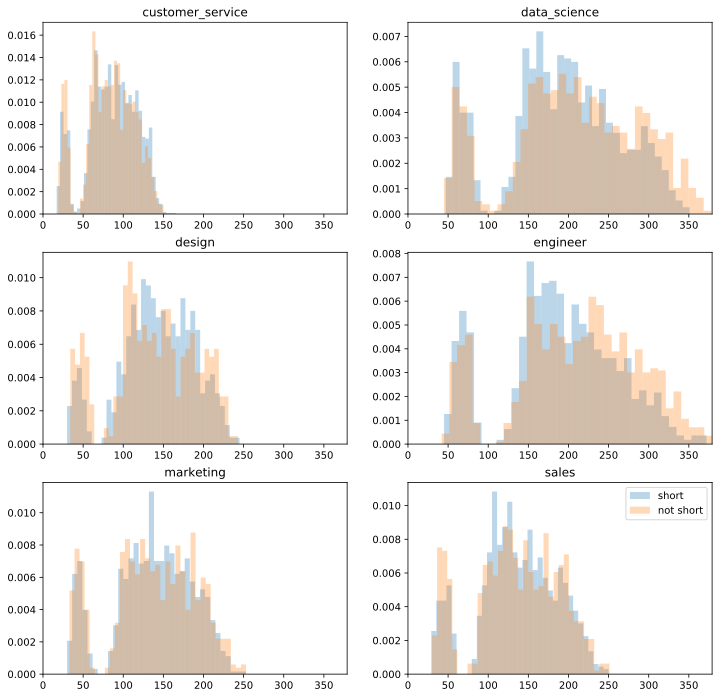

In [242]:
plt.figure(figsize=(12,12))
arrangement = (3, 2)
index = 1
max_salary = max(emps_left.salary)
for gp_name, gp_df in emps_left.groupby('dept'):
    plt.subplot(*arrangement, index)
    plt.gca().title.set_text(gp_name)
    plt.hist(gp_df[gp_df['is_short']].salary/1000, label='short', bins=35, alpha=0.3, density=True)
    plt.hist(gp_df[~gp_df['is_short']].salary/1000, label='not short', bins=35, alpha=0.3, density=True)
    plt.xlim(0, max_salary/1000)
    index += 1
plt.legend()

Basic takeaways: 

| Department | Conclusion |
| --- | --- |
| Customer service | Doesn't seem to have a significant salary dependence. |
| Data Science | See improvement in retention for salaries above 250k |
| Design | See improvement in retention fo salaries below 110k or above 190k. Could be related to senority. Recall that design is our smallest department, so there will be the greatest errors associated with this. |
| Engineer | We see that we retain engineers with more than 225k 

In [193]:
emps_left.seniority = emps_left.seniority.apply(lambda x: min(x, 29))

In [192]:
emps_left.seniority.value_counts().sort_index()

1     430
2     500
3     447
4     422
5     533
6     571
7     511
8     586
9     522
10    523
11    512
12    583
13    500
14    508
15    505
16    534
17    478
18    457
19    497
20    469
21    455
22    405
23    430
24    398
25    403
26    359
27    342
28    320
29    308
98      1
99      1
Name: seniority, dtype: int64

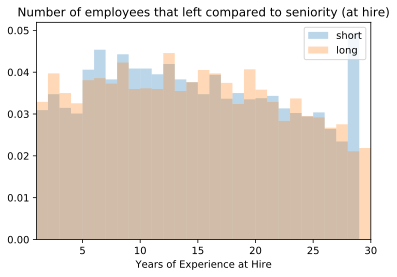

In [260]:
plt.hist(emps_left[emps_left['is_short']].seniority, alpha=0.3, label='short', 
         bins=max(emps_left[emps_left['is_short']].seniority) -
              min(emps_left[emps_left['is_short']].seniority), density=True)
plt.hist(emps_left[~emps_left['is_short']].seniority, alpha=0.3, label='long', 
         bins=max(emps_left[~emps_left['is_short']].seniority) -
              min(emps_left[emps_left['is_short']].seniority), density=True)
plt.xlabel('Years of Experience at Hire')
plt.title('Number of employees that left compared to seniority (at hire)')
plt.xlim(1, 30)
plt.legend();

For junior employees (<5 years experience) we see about the same fraction of employees are early leavers, but  experienced employees (particuarly in the 5 - 12 years of experience range) are more likely to leave within 500 days. For employees with more than 15 years experience this seems to balance out again.

This may indicate that we have a problem retaining mid-career employees, but are able to retain those that are junior (<5 years) and those at the end of their career (>15 years).

In [286]:
def estimate_p_value(seniority_range=(0,5), df=emps_left, show_msg=True):
    lower, upper = seniority_range
    emps_mask = ((lower <= emps_left.seniority) & (emps_left.seniority <= upper))
    num_in_range, p_short_in_range = emps_mask.sum(), df[emps_mask].is_short.mean()
    num_out_range, p_short_out_range = ((~emps_mask).sum()), df[~emps_mask].is_short.mean()
    
    p_pooled = df.is_short.mean()
    std_var = p_pooled*(1-p_pooled)*(1/num_in_range + 1/num_out_range)
    z_score = abs(p_short_in_range - p_short_out_range) / np.sqrt(std_var)
    p_value = 2*(1 - norm.cdf(z_score))
    if show_msg:
        msg = f"""
        Rate of short (<500 days) employment:
          Employees with seniority between {lower} and {upper} years: {p_short_in_range*100:6.4f}%
          Employees with seniority outside above range: {p_short_out_range*100:6.4f}%
          Chance of this difference if populations are the same: {p_value*100:6.4}%
        """
        print(msg)
    return p_value

estimate_p_value();


        Rate of short (<500 days) employment:
          Employees with seniority between 0 and 5 years: 52.8302%
          Employees with seniority outside above range: 54.6430%
          Chance of this difference if populations are the same:  10.99%
        


In [287]:
estimate_p_value(seniority_range=(5, 12));


        Rate of short (<500 days) employment:
          Employees with seniority between 5 and 12 years: 56.0931%
          Employees with seniority outside above range: 53.4955%
          Chance of this difference if populations are the same: 0.4647%
        


In [288]:
estimate_p_value(seniority_range=(12, 100));


        Rate of short (<500 days) employment:
          Employees with seniority between 12 and 100 years: 53.8036%
          Employees with seniority outside above range: 55.0837%
          Chance of this difference if populations are the same:  14.16%
        


## Company differences?

In [294]:
company_differences = emps_left.groupby('company_id').is_short.agg(['count', 'sum', 'mean'])
company_differences

,count,sum,mean
company_id,,,
1,4621,2501.0,0.541225
2,2206,1165.0,0.528105
3,1531,826.0,0.539517
4,1153,659.0,0.571552
5,983,530.0,0.539166
6,712,395.0,0.554775
7,692,371.0,0.536127
8,579,335.0,0.578584
9,529,282.0,0.533081


Firms 11 and 12 seem to have too few employees to say anything meaningful. Let's exclude them and look at distribution of times for the firms that have left.

In [302]:
emps_left['tenure_days'] = emps_left.tenure.dt.days

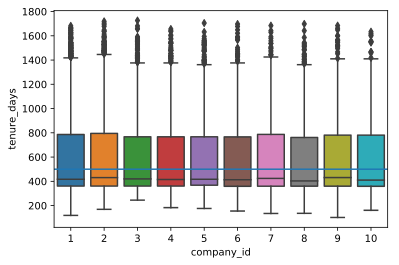

In [305]:
sns.boxplot(x='company_id', y='tenure_days', data=emps_left[emps_left.company_id < 11])
plt.gca().axhline(500)

The upper quartile, median, and lower quartiles all look broadly similiar, so there doesn't seem to be a large company dependence. With more time, I would look to see if the different distribution of employees within each department has a different distribution (e.g. are data scientists leaving earlier in company 4, but being masked by a higher proportion of marketing that makes the median look approximately the same).

The data set I would start with is looking at each department's fraction of short-term (<500 days) employees and compare across different companies:

In [307]:
emps_left[emps_left.company_id < 11].groupby(['dept', 'company_id']).is_short.agg(['count', 'sum', 'mean'])

count     sum      mean
dept             company_id                         
customer_service 1            1803  1005.0  0.557404
                 2             840   479.0  0.570238
                 3             545   286.0  0.524771
                 4             415   229.0  0.551807
                 5             355   206.0  0.580282
                 6             262   147.0  0.561069
                 7             269   141.0  0.524164
                 8             219   132.0  0.602740
                 9             186    90.0  0.483871
                 10            190   100.0  0.526316
data_science     1             565   279.0  0.493805
                 2             269   124.0  0.460967
                 3             194   104.0  0.536082
                 4             161    95.0  0.590062
                 5             114    57.0  0.500000
                 6              86    45.0  0.523256
                 7              86    45.0  0.523256
                 8              80    49.0  0.612500
                 9              71    40.0  0.563380
                 10             52    26.0  0.500000
design           1             269   138.0  0.513011
                 2             126    58.0  0.460317
                 3              81    48.0  0.592593
                 4              61    32.0  0.524590
                 5              71    45.0  0.633803
                 6              45    25.0  0.555556
                 7              37    21.0  0.567568
                 8              24    16.0  0.666667
                 9              41    30.0  0.731707
                 10             23    14.0  0.608696
engineer         1             748   385.0  0.514706
                 2             384   175.0  0.455729
                 3             292   153.0  0.523973
                 4             208   108.0  0.519231
                 5             180    84.0  0.466667
                 6             116    56.0  0.482759
                 7             125    67.0  0.536000
                 8             103    50.0  0.485437
                 9             106    58.0  0.547170
                 10             94    46.0  0.489362
marketing        1             620   338.0  0.545161
                 2             295   155.0  0.525424
                 3             214   115.0  0.537383
                 4             157    97.0  0.617834
                 5             114    61.0  0.535088
                 6             118    71.0  0.601695
                 7              77    43.0  0.558442
                 8              68    39.0  0.573529
                 9              62    31.0  0.500000
                 10             56    35.0  0.625000
sales            1             616   356.0  0.577922
                 2             292   174.0  0.595890
                 3             205   120.0  0.585366
                 4             151    98.0  0.649007
                 5             149    77.0  0.516779
                 6              85    51.0  0.600000
                 7              98    54.0  0.551020
                 8              85    49.0  0.576471
                 9              63    33.0  0.523810
                 10             65    40.0  0.615385